## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd

import re, nltk, spacy, string
nlp = spacy.load('en_core_web_sm')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from collections import Counter

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Optional - Mount drive and download data for Colab

In [135]:
'''
import glob
import os
import shutil
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive',force_remount=True)
# Define the path where you want to save the data in your Google Drive
folder_path = '/content/drive/My Drive/Ticket_Classification'
'''

"\nimport glob\nimport os\nimport shutil\nfrom google.colab import drive\n# Mount Google Drive\ndrive.mount('/content/drive',force_remount=True)\n# Define the path where you want to save the data in your Google Drive\nfolder_path = '/content/drive/My Drive/Ticket_Classification'\n"

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file
data_path=f'{folder_path}/complaints-2021-05-14_08_16.json'
f = open(data_path,'r', encoding="utf-8")# Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

In [5]:
### # Opening JSON file
### f = open('complaints-2021-05-14_08_16.json','r', encoding="utf-8")# Write the path to your data file and load it
###
### # returns JSON object as
### # a dictionary
### data = json.load(f)
### df=pd.json_normalize(data)

## Data preparation

In [7]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
#print the column names
print(f'Column names : {list(df.columns)}')

Column names : ['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [9]:
#Check and identify pattern
pattern1=r'^_source.'
cleaned_columns=[re.sub(pattern1,'',column) for column in df.columns ]
print(cleaned_columns)
#Check and identify pattern
pattern2=r'^_'
cleaned_columns=[re.sub(pattern2,'',column) for column in cleaned_columns ]
print(cleaned_columns)

['_index', '_type', '_id', '_score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']
['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']


In [10]:
#Assign new column names
df.columns=cleaned_columns
df.head(2)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


In [11]:
print(f'Count of null values {df["complaint_what_happened"].isnull().sum()}')
print('Count of empty values' , (df["complaint_what_happened"]=='').sum())

Count of null values 0
Count of empty values 57241


In [12]:
df[df["complaint_what_happened"]==''].head(2)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided


In [13]:
#Assign nan in place of blanks in the complaints column
df["complaint_what_happened"]=df["complaint_what_happened"].replace('',np.nan)
df.head(2)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


In [14]:
#Remove all rows where complaints column is nan
df=df[~ df["complaint_what_happened"].isnull() ]
df.reset_index(drop=True, inplace=True)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


### Check length of chars in complaint columns

In [15]:
df["complaint_what_happened"].str.len().describe([0.10,0.20,0.25,0.50,0.75,0.90,0.95,0.97,0.99])

,complaint_what_happened
count,21072.000000
mean,1384.006312
std,1502.196518
min,19.000000
10%,283.000000
20%,450.000000
25%,528.000000
50%,983.000000
75%,1738.000000
90%,2922.900000


#### Check columns having less chars

In [16]:
df[df["complaint_what_happened"].str.len()<20]["complaint_what_happened"]

,complaint_what_happened
5799,inquiry not removed
8697,Chase will not help


#### Check columns having more chars

In [17]:
df[df["complaint_what_happened"].str.len()>6915]["complaint_what_happened"]

,complaint_what_happened
39,I am writing you to file a complaint about an ...
82,Early in XXXX I became the XXXX XXXX of the US...
101,COMPLAINT : Chase bank has denied me from open...
111,I received an offer from Chase XXXX Visa promi...
131,"RE : Complaint Against JP Morgan Chase, XXXX H..."
...,...
20751,My husband and I have been loyal chase custome...
20763,I started a XXXX XXXX XXXX and XXXX company a...
20797,"XX/XX/XXXX I phoned Chase bank, and applied a ..."
21012,On XX/XX/XXXX there was a hail storm in XXXX X...


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [18]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text,test=False):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    if test:
        print(f'Original Text:\n{"-"*100}\n{text}\n{"="*100}')
    # Make text lowercase
    cleaned_text=text.lower()
    if test:
        print(f'After lowercase:\n{"-"*100}\n{cleaned_text}\n{"="*100}')
    # Remove text in square brackets
    pattern=r'\[*?\]'
    cleaned_text=re.sub(pattern,'',cleaned_text)
    if test:
        print(f'After removing square brackets:\n{"-"*100}\n{cleaned_text}\n{"="*100}')
    # Remove punctuation
    pattern=r'[%s]' % re.escape(string.punctuation)
    cleaned_text=re.sub(pattern,'',cleaned_text)
    if test:
        print(f'After removing punctuation:\n{"-"*100}\n{cleaned_text}\n{"="*100}')
    # Remove words containing numbers
    pattern=r'\w*\d\w*'
    cleaned_text=re.sub(pattern,'',cleaned_text)
    if test:
        print(f'After removing words containing numbers:\n{"-"*100}\n{cleaned_text}\n{"="*100}')
    return cleaned_text

In [19]:
#Write your function to Lemmatize the texts
def lema_text(text, test=False):
    '''Lemmatize the texts.'''
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    lema_text=" ".join(sent)
    if test:
        print(f'After Lemmatization:\n{"-"*100}\n{lema_text}\n{"="*100}')
    return lema_text

In [20]:
string_test=df.loc[1,"complaint_what_happened"]
string_test_cleaned=clean_text(string_test,test=True)

Original Text:
----------------------------------------------------------------------------------------------------
I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.
After lowercase:
----------------------------------------------------------------------------------------------------
i upgraded my xxxx xxxx card in xx/xx/2018 and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx   changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.
After removing square brackets:
----------------------

In [56]:
# Efficient bulk processing using spaCy pipe
def lemmatize_texts(texts, test=False):
    """Lemmatize a list of texts."""
    stopwords = nlp.Defaults.stop_words
    if test:
        print(f'Original Text:\n{"-"*100}\n{texts}\n{"="*100}')
    lemmatized = []
    for doc in nlp.pipe(texts, batch_size=1000, disable=["parser", "ner"]):
        lemmatized.append(" ".join([ token.lemma_ for token in doc if token.text not in set(stopwords) ]))
    if test:
        print(f'After Lemmatization:\n{"-"*100}\n{lemmatized}\n{"="*100}')
    return lemmatized

In [57]:
string_test_lema=lemmatize_texts([string_test_cleaned],test=True)

Original Text:
----------------------------------------------------------------------------------------------------
['i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me']
After Lemmatization:
----------------------------------------------------------------------------------------------------
['upgrade xxxx xxxx card   tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx    change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead']


In [58]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean=df[['complaint_what_happened']]
print(df_clean.shape)

(21072, 1)


In [59]:
# Clean data
df_clean = df_clean.copy()
df_clean.loc[:,'complaint_what_happened_lemmatized']=df_clean['complaint_what_happened'].apply(lambda x: clean_text(x))

In [60]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...


In [61]:
# Apply lemmatization
df_clean = df_clean.copy()
df_clean.loc[:,'complaint_what_happened_lemmatized'] = lemmatize_texts(df_clean['complaint_what_happened_lemmatized'])

In [62]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized
0,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade an...
2,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application sub...
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer a...
4,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund c...


In [63]:
#Write your function to extract the POS tags

def pos_tag(text, test=False):
    """Extract singular nouns (NN) from text using POS tagging."""
    pos_tags = []
    # Wrap the input text in a list to use `nlp.pipe`
    for doc in nlp.pipe([text], disable=["parser", "ner"]):
        for token in doc:
            if token.tag_ == "NN":  # Check if the token is a singular noun
                pos_tags.append(token.text)

    pos_tags_filtered = " ".join(pos_tags)

    if test:
        print(f'Before POS removed:\n{"-"*100}\n{text}\n{"="*100}')
        print(f'After POS removed:\n{"-"*100}\n{pos_tags_filtered}\n{"="*100}')

    return pos_tags_filtered

In [64]:
string_test=df_clean.loc[1,"complaint_what_happened_lemmatized"]
string_test_POS_removed=pos_tag(string_test,test=True)

Before POS removed:
----------------------------------------------------------------------------------------------------
upgrade xxxx xxxx card   tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx    change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead
After POS removed:
----------------------------------------------------------------------------------------------------
card agent upgrade anniversary date change agent information order account anniversary date agent


In [65]:
df_clean = df_clean.copy()
# This column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"]
df_clean.loc[:,'complaint_POS_removed'] = df_clean['complaint_what_happened_lemmatized'].apply(lambda x: pos_tag(x))

In [66]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade an...,card agent upgrade anniversary date change age...
2,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application sub...,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer a...,book ticket come offer ticket reward card info...
4,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund c...,son deposit chase account fund bank account pa...


In [137]:
'''
import glob
import os
import shutil
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive',force_remount=True)
# Define the path where you want to save the data in your Google Drive
consolidated_folder = f'{folder_path}/file'
# Path to the CSV file you want to copy
df_clean.to_csv('df_clean.csv')
source_file = '/content/df_clean.csv'
# Step 1: Check if the consolidated folder exists
if os.path.exists(consolidated_folder):
    # If it exists, delete the folder and its contents
    shutil.rmtree(consolidated_folder)
    print(f"{consolidated_folder} folder has been deleted.")
else:
    print(f"{consolidated_folder} folder does not exist.")
# Create the consolidated folder
os.makedirs(consolidated_folder, exist_ok=True)
# Step 2: Copy the file to the consolidated destination
shutil.copy(source_file, os.path.join(consolidated_folder, os.path.basename(source_file)))
print(f"File {source_file} has been copied to {consolidated_folder}.")
'''

'\nimport glob\nimport os\nimport shutil\nfrom google.colab import drive\n# Mount Google Drive\ndrive.mount(\'/content/drive\',force_remount=True)\n# Define the path where you want to save the data in your Google Drive\nconsolidated_folder = f\'{folder_path}/file\'\n# Path to the CSV file you want to copy\ndf_clean.to_csv(\'df_clean.csv\')\nsource_file = \'/content/df_clean.csv\'\n# Step 1: Check if the consolidated folder exists\nif os.path.exists(consolidated_folder):\n    # If it exists, delete the folder and its contents\n    shutil.rmtree(consolidated_folder)\n    print(f"{consolidated_folder} folder has been deleted.")\nelse:\n    print(f"{consolidated_folder} folder does not exist.")\n# Create the consolidated folder\nos.makedirs(consolidated_folder, exist_ok=True)\n# Step 2: Copy the file to the consolidated destination\nshutil.copy(source_file, os.path.join(consolidated_folder, os.path.basename(source_file)))\nprint(f"File {source_file} has been copied to {consolidated_folder}

In [139]:
df_clean=pd.read_csv('df_clean.csv')
df_clean.drop(columns=['Unnamed: 0'],inplace=True)
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade an...,card agent upgrade anniversary date change age...
2,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application sub...,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer a...,book ticket come offer ticket reward card info...
4,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund c...,son deposit chase account fund bank account pa...


In [140]:
df_clean[df_clean["complaint_POS_removed"].isnull()]

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed
58,ChaseMortgagehasautomaticallydeducted2mortgage...,NaN,NaN
1487,Please forward the information to J.P Morgan C...,forward information jp morgan chase bank thank,NaN
1619,Did not inquire this,inquire,NaN
1931,I keep getting billed for lock box with chase ...,get bill lock box chase not,NaN
2813,IreceivedanemailXX/XX/XXXXthatmycreditcardswer...,\n\n\n\n\n,NaN
3194,IacceptedapromotionalofferonmyChaseSapphirecre...,NaN,NaN
4988,Throughoutthelastfewmonthswehavehadawebsite(XX...,NaN,NaN
5629,XXXX BANK XXXX {$140.00} {$200.00} 71 % Revolv...,xxxx bank xxxx revolve negative xxxx xxxx...,NaN
7741,"OnmyXXXXXXXX,XXXXstatement,Ihad{$0.00}purchase...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n myxxxxxxxxxxxxsta...,NaN
9887,I want to know what involvement JP Morgan has ...,want know involvement jp morgan mortgage,NaN


In [141]:
#Remove all rows where complaints column is nan
df_clean=df_clean[~ df_clean["complaint_POS_removed"].isnull() ]
df_clean.reset_index(drop=True, inplace=True)

In [142]:
df_clean[df_clean["complaint_POS_removed"].isnull()]

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




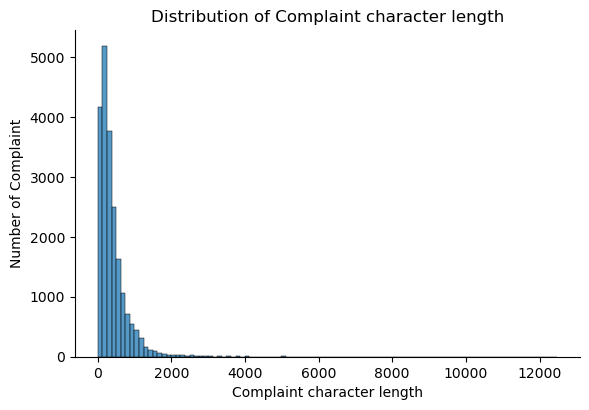

In [143]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_lens=df_clean["complaint_POS_removed"].str.len()
sns.displot(complaint_lens,bins=100,height=4, aspect=1.5)
plt.title('Distribution of Complaint character length')
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

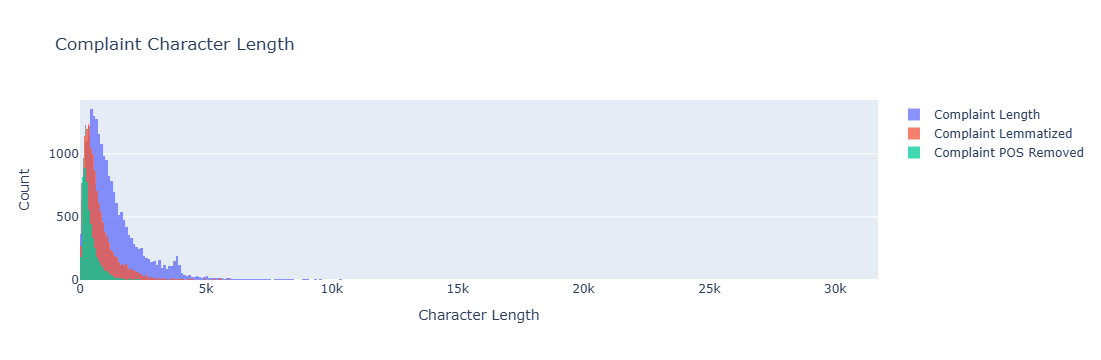

In [144]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean = df_clean.copy()
df_clean['complaint_length'] = df_clean['complaint_what_happened'].str.len()
df_clean['complaint_what_happened_lemmatized_length'] = df_clean['complaint_what_happened_lemmatized'].str.len()
df_clean['complaint_POS_removed_length'] = df_clean['complaint_POS_removed'].str.len()


fig = go.Figure()
fig.add_trace(go.Histogram(x=df_clean['complaint_length'], name='Complaint Length'))
fig.add_trace(go.Histogram(x=df_clean['complaint_what_happened_lemmatized_length'], name='Complaint Lemmatized'))
fig.add_trace(go.Histogram(x=df_clean['complaint_POS_removed_length'], name='Complaint POS Removed'))
fig.update_layout(barmode='overlay', title='Complaint Character Length', xaxis_title='Character Length', yaxis_title='Count')
fig.update_traces(opacity=0.75)
fig.show()

In [145]:
#Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

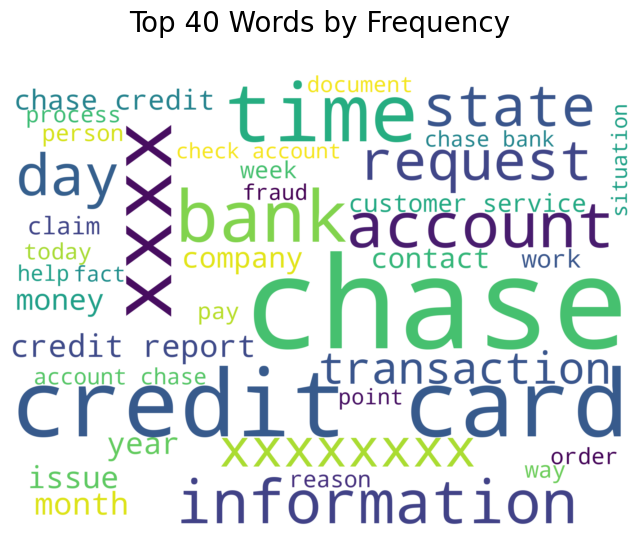

In [148]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
stopwords = nlp.Defaults.stop_words
wordcloud=WordCloud(stopwords= stopwords, background_color='white', width=2000, height=1500, max_words=40).generate(' '.join(df_clean['complaint_POS_removed']))
# Display the Word Cloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.title("Top 40 Words by Frequency\n", fontsize=20)
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [149]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_words(corpus, n=None,count=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

chase 54043
account 41339
credit 33612
xxxx 33326
card 29904
payment 21108
bank 17559
time 15919
charge 15350
day 12913


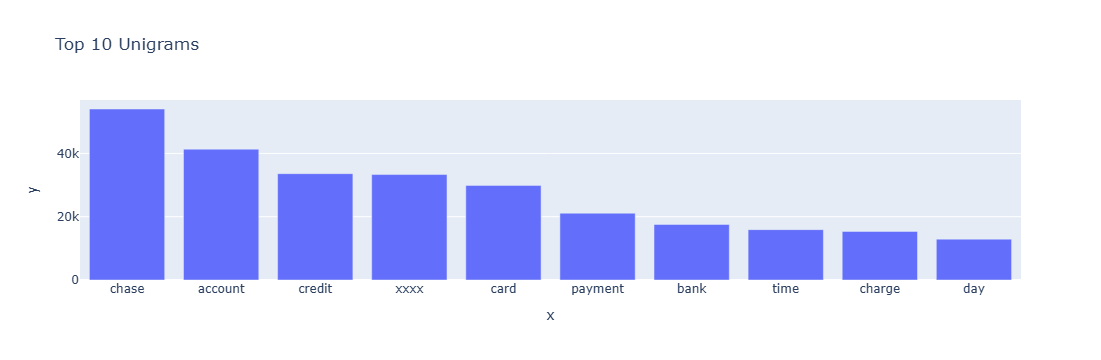

In [151]:
#Print the top 10 words in the unigram frequency
unigram = get_top_n_words(df_clean['complaint_clean'], 1,10)
for word, freq in unigram:
    print(word, freq)
px.bar(x=[word for word, freq in unigram], y=[freq for word, freq in unigram], title='Top 10 Unigrams')

In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).


credit card 12786
credit report 3899
chase credit 3070
customer service 2931
call chase 2756
account chase 2233
chase bank 2179
check account 2129
xxxx xxxx 2085
chase account 2016


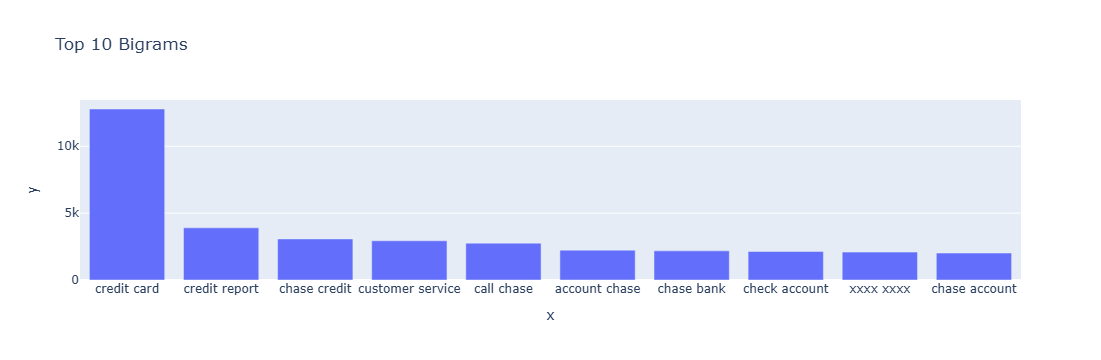

In [153]:
#Print the top 10 words in the bigram frequency
bigram = get_top_n_words(df_clean['complaint_clean'], 2,10)
for word, freq in bigram:
    print(word, freq)
px.bar(x=[word for word, freq in bigram], y=[freq for word, freq in bigram], title='Top 10 Bigrams')

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).


chase credit card 2204
credit card account 1046
credit card company 972
credit card chase 717
xxxx credit card 674
chase customer service 555
inquiry credit report 484
credit card credit 416
credit card xxxx 403
charge credit card 390


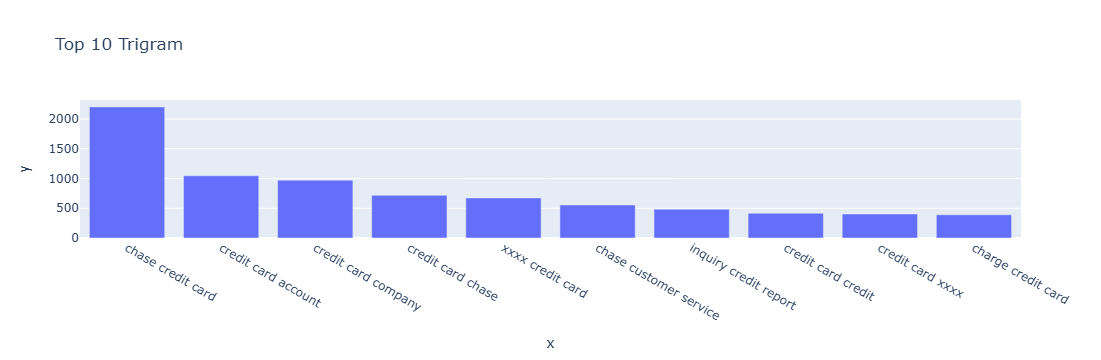

In [154]:
#Print the top 10 words in the trigram frequency
trigram = get_top_n_words(df_clean['complaint_clean'], 3,10)
for word, freq in trigram:
    print(word, freq)
px.bar(x=[word for word, freq in trigram], y=[freq for word, freq in trigram], title='Top 10 Trigram')

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [155]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')

In [157]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service chase debt verificat...,486,300,147,morning help bank service chase debt verificat...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade an...,card agent upgrade anniversary date change age...,355,210,97,card agent upgrade anniversary date change age...
2,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application sub...,chase card report application submit identity ...,224,134,101,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer a...,book ticket come offer ticket reward card info...,1502,762,411,book ticket come offer ticket reward card info...
4,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund c...,son deposit chase account fund bank account pa...,477,284,167,son deposit chase account fund bank account pa...
...,...,...,...,...,...,...,...
21054,After being a Chase Card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,679,383,264,chase card customer decade solicitation credit...
21055,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...,2114,1172,700,credit card provider ask claim purchase protec...
21056,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer chase year trust mobile ban...,2319,1345,700,risk consumer chase year trust mobile banking...
21057,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ve chase credit card c...,credit yrs credit card chase freedom problem t...,2171,1163,536,credit yrs credit card chase freedom problem t...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = #write the value you want to test out

#keep the random_state =40
nmf_model = #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



